<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #2 - Parte I: Entrenamiento de Autoencoders (AEs) y RBMs en MNIST </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

## Tabla de Contenidos
* [1.0 Helper](#helper)
    * [Parte (a)](#1.0a)
* [1.1 Reducción de dimensionalidad](#dim)
    * [Parte (a)](#1.1a)
    * [Parte (b)](#1.1b)
    * [Parte (c)](#1.1c)
    * [Parte (d)](#1.1d)
    * [Parte (e)](#1.1e)
    * [Parte (f)](#1.1f)
    * [Parte (g)](#1.1g)
    * [Parte (h)](#1.1h)
    * [Parte (i)](#1.1i)
    * [Parte (j)](#1.1j)
* [1.2 Denoising](#den)
    * [Parte (a)](#1.2a)
    * [Parte (b)](#1.2b)
    * [Parte (c)](#1.2c)
    * [Parte (d)](#1.2d)
    * [Parte (e)](#1.2e)
    * [Parte (f)](#1.2f)
    * [Parte (g)](#1.2g)
* [1.3 Pre-entrenamiento](#pretr)
    * [Parte (a)](#1.3a)
    * [Parte (b)](#1.3b)
    * [Parte (c)](#1.3c)
    * [Parte (d)](#1.3d)
    * [Parte (e)](#1.3e)
    * [Parte (f)](#1.3f)
    * [Parte (g)](#1.3g)
    * [Parte (h)](#1.3h)

In [29]:
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from keras_helper import load_keras_model as load

from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model, load_model, save_model
from keras.optimizers import SGD
from keras.objectives import binary_crossentropy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
from sklearn.manifold import TSNE

<div id='helper'/>
## 1.0 - Helper

<div id='1.0a'/>
### Parte (a)

A continuación se presenta la función de carga de datos solicitada, junto con otras funciones de ayuda (visualización) utilizadas en esta parte de la tarea.

In [2]:
def load_helper(nval=1000):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # 0-1 scaling
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    # reshaping
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    # training / validation split
    X_val = X_train[-nval:]
    y_val = y_train[-nval:]
    X_train = X_train[:-nval]
    y_train = y_train[:-nval]
    # correct format
    y_train = np_utils.to_categorical(y_train, 10)
    y_val = np_utils.to_categorical(y_val, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    return X_train, X_val, X_test, y_train, y_val, y_test


def show_results(data_dict, x_axis, title=None, xlabel=None, ylabel=None, loc=1):
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca()
    ax.set_xticks(x_axis)
    plt.xlim(x_axis[0]-1, x_axis[-1]+1)
    if title is not None: plt.title(title)
    for label,data in data_dict.items():
        plt.plot(x_axis, data, 'o-', label=label)
    plt.legend(loc=loc)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)
    plt.grid()
    plt.show()   

In [3]:
### LOADING DATA
X_train, X_val, X_test, y_train, y_val, y_test = load_helper()

<div id='dim'/>
## 1.1 - Reducción de Dimensionalidad

### Parte (a)

In [16]:
def train_basic_ae(X_train, X_val, hidden_size=32, activation1='sigmoid', activation2='sigmoid'):
    input_img = Input(shape=(784,))
    encoded = Dense(hidden_size, activation=activation1)(input_img)
    decoded = Dense(784, activation=activation2)(encoded)
    # building encoder, decoder and autoencoder
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(hidden_size,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=25, shuffle=True, 
                    validation_data=(X_val, X_val), verbose=0)
    # saving results
    encoder.save('enc_{0}d_{1}.h5'.format(hidden_size, activation1))
    decoder.save('dec_{0}d_{1}.h5'.format(hidden_size, activation1))
    autoencoder.save('ae_{0}d_{1}.h5'.format(hidden_size, activation1))
    return encoder, decoder, autoencoder

#### Función de activación: `Sigmoidal` (En `encoder` y `decoder`)

In [ ]:
[enc_2d_sigmoid, dec_2d_sigmoid, ae_2d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=2)
[enc_8d_sigmoid, dec_8d_sigmoid, ae_8d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=8)
[enc_32d_sigmoid, dec_32d_sigmoid, ae_32d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=32)
[enc_64d_sigmoid, dec_64d_sigmoid, ae_64d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=64)

Se elige como error de reconstrucción el MSE (*Mean squared error*). Esto pues más adelante se requiere comparar los resultados con PCA, el cual no necesariamente mantiene sus predicciones en el intervalo $[0,1]$, esto es, para hacer una comparación más justa.

In [4]:
# reconstruction error: MSE
def rec_err(X, X_pred):
    m,n = X.shape
    aux = ((X - X_pred)**2).sum(axis=1) / n
    return aux.sum() / m

In [92]:
print('Sigmoid + d=2')
print('Porcentaje de compresion: {0}%'.format(2./784 * 100))
err = rec_err(X_test, ae_2d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('Sigmoid + d=8')
print('Porcentaje de compresion: {0}%'.format(8./784 * 100))
err = rec_err(X_test, ae_8d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('Sigmoid + d=32')
print('Porcentaje de compresion: {0}%'.format(32./784 * 100))
err = rec_err(X_test, ae_32d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('Sigmoid + d=64')
print('Porcentaje de compresion: {0}%'.format(64./784 * 100))
err = rec_err(X_test, ae_64d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0}'.format(err))

Sigmoid + d=2
Porcentaje de compresion: 0.255102040816%
Error de reconstruccion: 0.0674703491211 

Sigmoid + d=8
Porcentaje de compresion: 1.02040816327%
Error de reconstruccion: 0.0674777709961 

Sigmoid + d=32
Porcentaje de compresion: 4.08163265306%
Error de reconstruccion: 0.0371436340332 

Sigmoid + d=64
Porcentaje de compresion: 8.16326530612%
Error de reconstruccion: 0.01936459198


#### Función de activación: `ReLU` (en `encoder`) y `Sigmoidal` (en `decoder`) 

In [ ]:
[enc_2d_relu, dec_2d_relu, ae_2d_relu] = train_basic_ae(X_train, X_val, hidden_size=2, activation1='relu')
[enc_8d_relu, dec_8d_relu, ae_8d_relu] = train_basic_ae(X_train, X_val, hidden_size=8, activation1='relu')
[enc_32d_relu, dec_32d_relu, ae_32d_relu] = train_basic_ae(X_train, X_val, hidden_size=32, activation1='relu')
[enc_64d_relu, dec_64d_relu, ae_64d_relu] = train_basic_ae(X_train, X_val, hidden_size=64, activation1='relu')

In [93]:
print('ReLU + d=2')
print('Porcentaje de compresion: {0}%'.format(2./784 * 100))
err = rec_err(X_test, ae_2d_relu.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('ReLU + d=8')
print('Porcentaje de compresion: {0}%'.format(8./784 * 100))
err = rec_err(X_test, ae_8d_relu.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('ReLU + d=32')
print('Porcentaje de compresion: {0}%'.format(32./784 * 100))
err = rec_err(X_test, ae_32d_relu.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('ReLU + d=64')
print('Porcentaje de compresion: {0}%'.format(64./784 * 100))
err = rec_err(X_test, ae_64d_relu.predict(X_test))
print('Error de reconstruccion: {0}'.format(err))

ReLU + d=2
Porcentaje de compresion: 0.255102040816%
Error de reconstruccion: 0.0557904296875 

ReLU + d=8
Porcentaje de compresion: 1.02040816327%
Error de reconstruccion: 0.0348007202148 

ReLU + d=32
Porcentaje de compresion: 4.08163265306%
Error de reconstruccion: 0.0100807395935 

ReLU + d=64
Porcentaje de compresion: 8.16326530612%
Error de reconstruccion: 0.0040022228241


In [5]:
# Almacenando resultados en listas
rec_err_ae_sigmoid = [0.0674703491211, 0.0674777709961, 0.0371436340332, 0.01936459198]
rec_err_ae_relu = [0.0557904296875, 0.0348007202148, 0.0100807395935, 0.0040022228241]

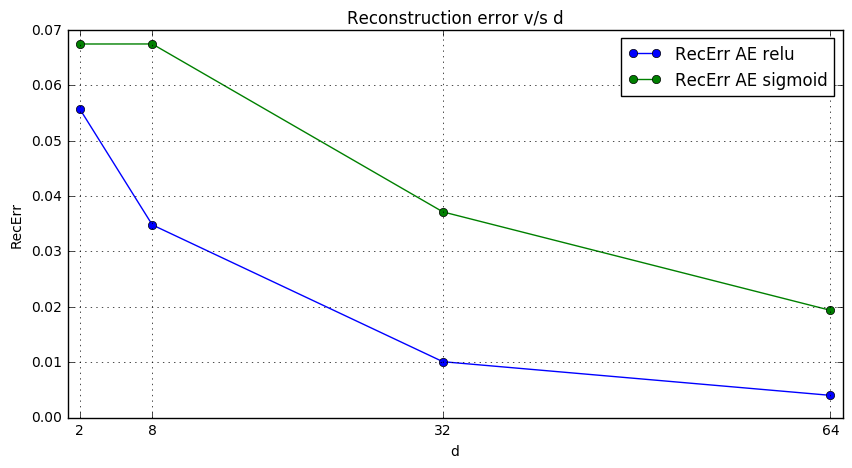

In [22]:
data_dict = {'RecErr AE sigmoid': rec_err_ae_sigmoid, 'RecErr AE relu':rec_err_ae_relu}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

**Nota:** No es posible ocupar en este caso una función de activación `ReLU` para el `decoder`, dado que esto da la posibilidad de obtener valores $\geq 1$ (Lo cual no es posible, pues la representación se definió de tal modo que los valores están en $[0,1]$).

### Parte (b)

In [6]:
def visualize_reconstruction(X_test, ae):
    decoded_test = ae.predict(X_test)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Encoder con `sigmoid` y `d=8`

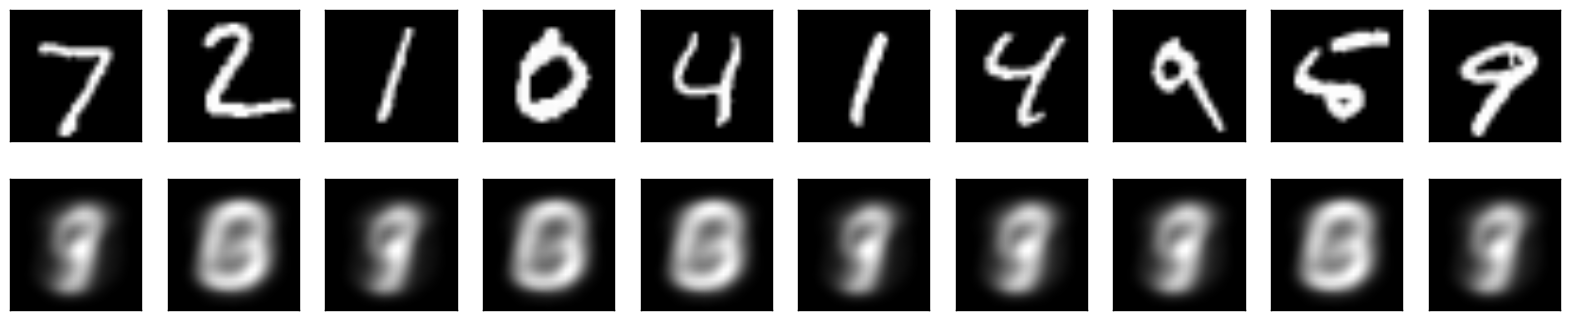

In [39]:
visualize_reconstruction(X_test, ae_8d_sigmoid)

#### Encoder con `sigmoid` y `d=64` 

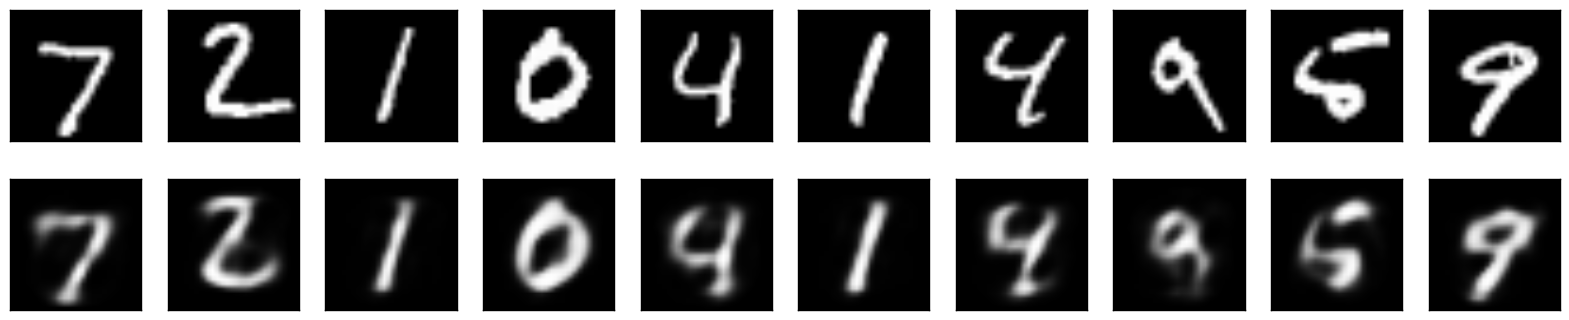

In [40]:
visualize_reconstruction(X_test, ae_64d_sigmoid)

#### Encoder con `relu` y `d=8`

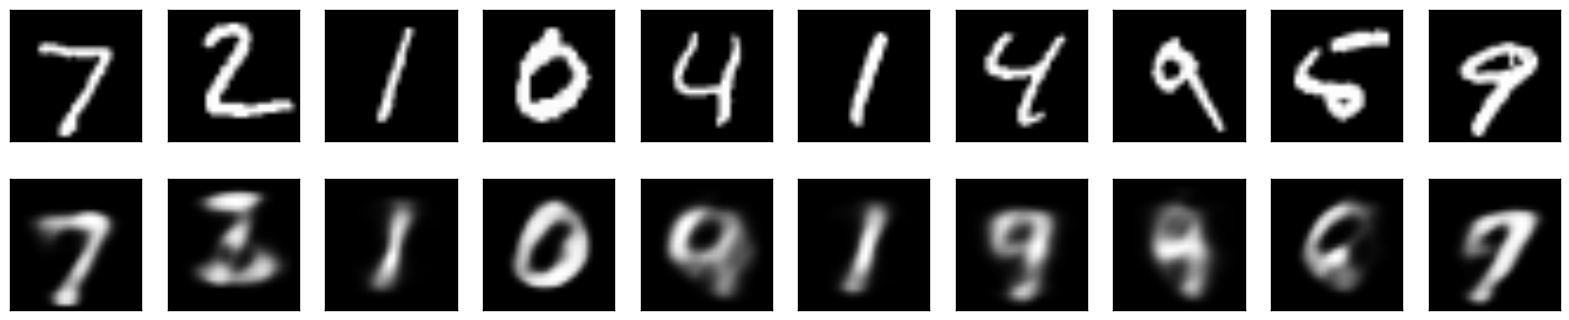

In [41]:
visualize_reconstruction(X_test, ae_8d_relu)

#### Encoder con `relu` y `d=64`

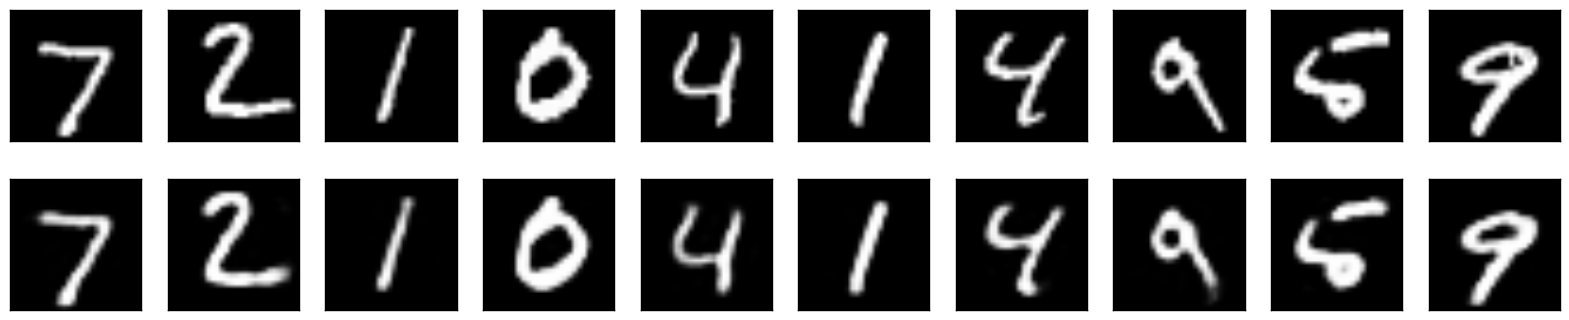

In [42]:
visualize_reconstruction(X_test, ae_64d_relu)

### Parte (c)

In [17]:
def knn_classification_accuracy(X_train, y_train, X_test, y_test, verbose=1):
    clf = KNeighborsClassifier(10)
    t0 = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time()-t0
    score = clf.score(X_test, y_test)
    if verbose:
        print('Classification Accuracy: %.2f' % score)
        print('Elapsed time: {0}[s] \n'.format(elapsed))
    del clf
    return score

In [25]:
print('Sigmoid + d=2')
knn_classification_accuracy(enc_2d_sigmoid.predict(X_train), y_train, enc_2d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=8')
knn_classification_accuracy(enc_8d_sigmoid.predict(X_train), y_train, enc_8d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=32')
knn_classification_accuracy(enc_32d_sigmoid.predict(X_train), y_train, enc_32d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=64')
knn_classification_accuracy(enc_64d_sigmoid.predict(X_train), y_train, enc_64d_sigmoid.predict(X_test), y_test)

print('ReLU + d=2')
knn_classification_accuracy(enc_2d_relu.predict(X_train), y_train, enc_2d_relu.predict(X_test), y_test)

print('ReLU + d=8')
knn_classification_accuracy(enc_8d_relu.predict(X_train), y_train, enc_8d_relu.predict(X_test), y_test)

print('ReLU + d=32')
knn_classification_accuracy(enc_32d_relu.predict(X_train), y_train, enc_32d_relu.predict(X_test), y_test)

print('ReLU + d=64')
knn_classification_accuracy(enc_64d_relu.predict(X_train), y_train, enc_64d_relu.predict(X_test), y_test)

print('Original data (No reduction)')
knn_classification_accuracy(X_train, y_train, X_test, y_test)

Sigmoid + d=2
Classification Accuracy: 0.00
Elapsed time: 0.448776960373[s] 

Sigmoid + d=8
Classification Accuracy: 0.18
Elapsed time: 0.112163066864[s] 

Sigmoid + d=32
Classification Accuracy: 0.83
Elapsed time: 0.181217908859[s] 

Sigmoid + d=64
Classification Accuracy: 0.95
Elapsed time: 0.304636001587[s] 

ReLU + d=2
Classification Accuracy: 0.22
Elapsed time: 0.0647070407867[s] 

ReLU + d=8
Classification Accuracy: 0.86
Elapsed time: 0.0793220996857[s] 

ReLU + d=32
Classification Accuracy: 0.96
Elapsed time: 0.166414022446[s] 

ReLU + d=64
Classification Accuracy: 0.95
Elapsed time: 0.311235189438[s] 

Original data (No reduction)
Classification Accuracy: 0.96
Elapsed time: 18.7843770981[s] 



In [8]:
# Almacenando resultados en listas
ca_ae_sigmoid = [0.00, 0.18, 0.83, 0.95]
ca_ae_relu = [0.22, 0.86, 0.96, 0.95]

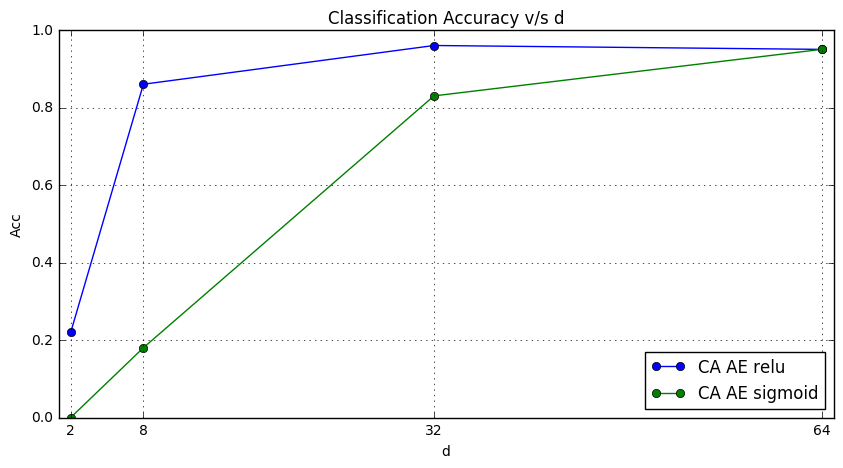

In [28]:
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

### Parte (d)

In [16]:
def clustering_accuracy(y, pred_labels, nclusters=10):
    true_pred = 0.0
    for i in range(0, nclusters):
        mvlabel = np.argmax(np.bincount(y[pred_labels==i]))
        true_pred += sum(y[pred_labels==i] == mvlabel)
    return true_pred/len(y)

def clustering_scores(X_train, y_train, verbose=1):
    y_train = np.argmax(y_train, axis=1)
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(X_train)
    ari = adjusted_rand_score(y_train, labels_pred)
    acc = clustering_accuracy(y_train, labels_pred)
    if verbose:
        print('Clustering ARI: {0}'.format(ari))
        print('Clustering ACC: {0} \n'.format(acc))
    del model
    return acc

In [42]:
print('Sigmoid + d=2')
clustering_scores(enc_2d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=8')
clustering_scores(enc_8d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=32')
clustering_scores(enc_32d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=64')
clustering_scores(enc_64d_sigmoid.predict(X_train), y_train)

print('ReLU + d=2')
clustering_scores(enc_2d_relu.predict(X_train), y_train)

print('ReLU + d=8')
clustering_scores(enc_8d_relu.predict(X_train), y_train)

print('ReLU + d=32')
clustering_scores(enc_32d_relu.predict(X_train), y_train)

print('ReLU + d=64')
clustering_scores(enc_64d_relu.predict(X_train), y_train)

print('Original data (No reduction)')
clustering_scores(X_train, y_train)

Sigmoid + d=2
Clustering ARI: 0.000272498252964
Clustering ACC: 0.119983050847 

Sigmoid + d=8
Clustering ARI: 0.000800324299906
Clustering ACC: 0.11813559322 

Sigmoid + d=32
Clustering ARI: 0.353451509837
Clustering ACC: 0.574966101695 

Sigmoid + d=64
Clustering ARI: 0.410933774352
Clustering ACC: 0.610050847458 

ReLU + d=2
Clustering ARI: 0.177531118763
Clustering ACC: 0.375813559322 

ReLU + d=8
Clustering ARI: 0.301972563823
Clustering ACC: 0.507186440678 

ReLU + d=32
Clustering ARI: 0.223556527212
Clustering ACC: 0.476542372881 

ReLU + d=64
Clustering ARI: 0.238850809743
Clustering ACC: 0.437288135593 

Original data (No reduction)
Clustering ARI: 0.360236626723
Clustering ACC: 0.590508474576 



In [10]:
# almacenando resultados en listas
ari_ae_sigmoid = [0.000272498252964, 0.000800324299906, 0.353451509837, 0.410933774352]
acc_ae_sigmoid = [0.119983050847, 0.11813559322, 0.574966101695, 0.610050847458]
ari_ae_relu = [0.177531118763, 0.301972563823, 0.223556527212, 0.238850809743]
acc_ae_relu = [0.375813559322, 0.507186440678, 0.476542372881, 0.437288135593]

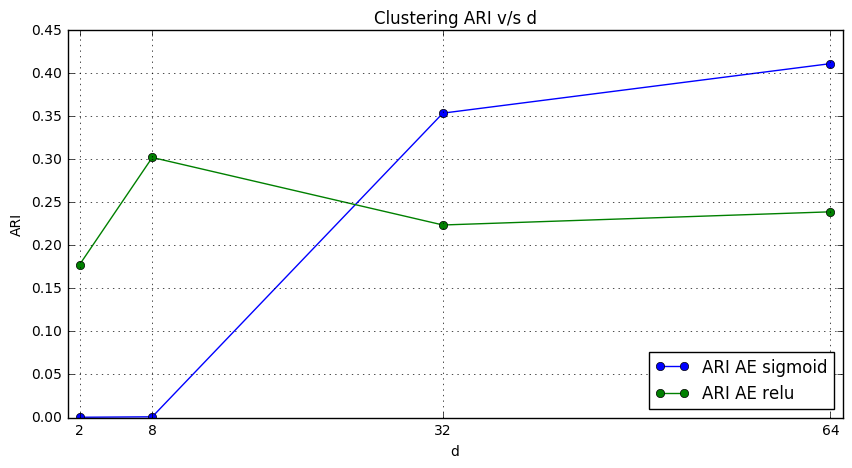

In [32]:
data_dict1 = {'ARI AE sigmoid': ari_ae_sigmoid, 'ARI AE relu':ari_ae_relu}
show_results(data_dict1, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ARI v/s d', loc=4)

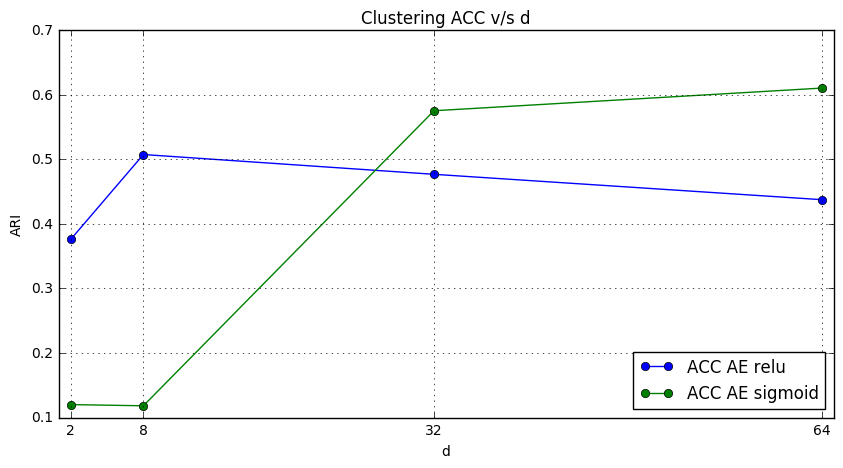

In [33]:
data_dict2 = {'ACC AE sigmoid': acc_ae_sigmoid, 'ACC AE relu':acc_ae_relu}
show_results(data_dict2, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ACC v/s d', loc=4)

### Parte (e)

In [12]:
def pca_reduction(X_train, X_test, d):
    pca = PCA(n_components=d)
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_train_rec = pca.inverse_transform(pca_train)
    pca_test = pca.transform(X_test)
    pca_test_rec = pca.inverse_transform(pca_test)
    del pca
    return pca_train, pca_train_rec, pca_test, pca_test_rec

In [14]:
# realizando la reduccion de dimensionalidad
pca_train_red = []; pca_train_rec = []
pca_test_red = []; pca_test_rec = []
for d in [2,8,32,64]:
    tr_red, tr_rec, ts_red, ts_rec = pca_reduction(X_train, X_test, d)
    pca_train_red.append(tr_red)
    pca_train_rec.append(tr_rec)
    pca_test_red.append(ts_red)
    pca_test_rec.append(ts_rec)

#### Errores de reconstrucción

In [15]:
rec_err_pca = []

print('PCA + d=2')
err = rec_err(X_test, pca_test_rec[0]); rec_err_pca.append(err)
print('Error de reconstruccion: {0} \n'.format(err))

print('PCA + d=8')
err = rec_err(X_test, pca_test_rec[1]); rec_err_pca.append(err)
print('Error de reconstruccion: {0} \n'.format(err))


print('PCA + d=32')
err = rec_err(X_test, pca_test_rec[2]); rec_err_pca.append(err)
print('Error de reconstruccion: {0} \n'.format(err))

print('PCA + d=64')
err = rec_err(X_test, pca_test_rec[3]); rec_err_pca.append(err)
print('Error de reconstruccion: {0}'.format(err))

PCA + d=2
Error de reconstruccion: 0.05566576047874694 

PCA + d=8
Error de reconstruccion: 0.03743710863405527 

PCA + d=32
Error de reconstruccion: 0.016826220785023837 

PCA + d=64
Error de reconstruccion: 0.00904692935273352


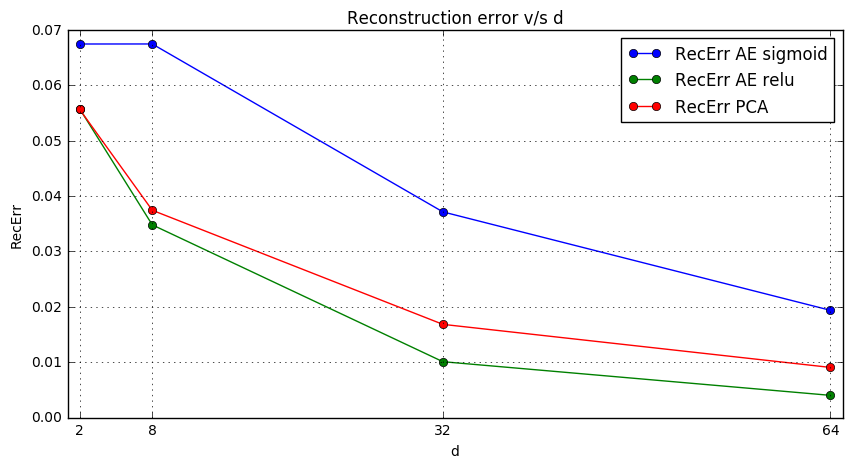

In [14]:
data_dict = {'RecErr AE sigmoid': rec_err_ae_sigmoid, 'RecErr AE relu':rec_err_ae_relu, 'RecErr PCA':rec_err_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

#### Desempeño en clasificación

In [18]:
ca_pca = []

print('PCA + d=2')
acc = knn_classification_accuracy(pca_train_red[0], y_train, pca_test_red[0], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0} \n'.format(acc))

print('PCA + d=8')
acc = knn_classification_accuracy(pca_train_red[1], y_train, pca_test_red[1], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0} \n'.format(acc))

print('PCA + d=32')
acc = knn_classification_accuracy(pca_train_red[2], y_train, pca_test_red[2], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0} \n'.format(acc))

print('PCA + d=64')
acc = knn_classification_accuracy(pca_train_red[3], y_train, pca_test_red[3], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0}'.format(acc))

PCA + d=2
Classification Accuracy: 0.2554 

PCA + d=8
Classification Accuracy: 0.8749 

PCA + d=32
Classification Accuracy: 0.9656 

PCA + d=64
Classification Accuracy: 0.9633


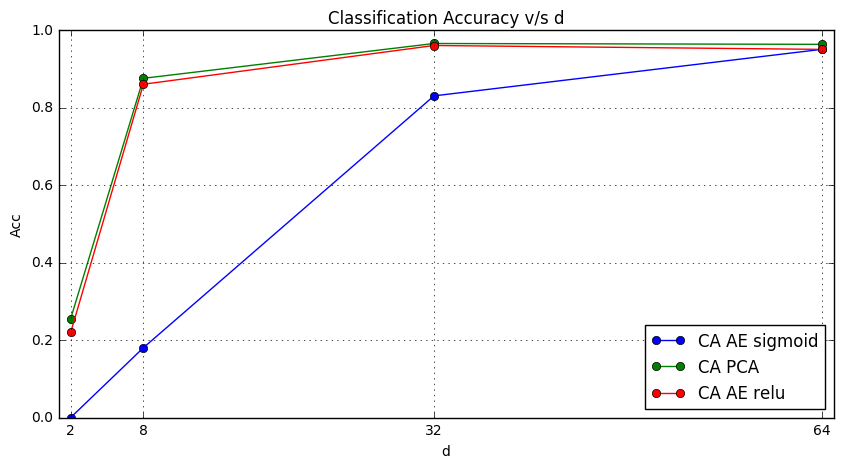

In [16]:
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu, 'CA PCA':ca_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

#### Desempeño en agrupamiento

In [19]:
acc_pca = []

print('PCA + d=2')
acc = clustering_scores(pca_train_red[0], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0} \n'.format(acc))

print('PCA + d=8')
acc = clustering_scores(pca_train_red[1], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0} \n'.format(acc))

print('PCA + d=32')
acc = clustering_scores(pca_train_red[2], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0} \n'.format(acc))

print('PCA + d=64')
acc = clustering_scores(pca_train_red[3], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0}'.format(acc))

PCA + d=2
Clustering ACC: 0.4089830508474576 

PCA + d=8
Clustering ACC: 0.5899322033898305 

PCA + d=32
Clustering ACC: 0.589406779661017 

PCA + d=64
Clustering ACC: 0.5903898305084746


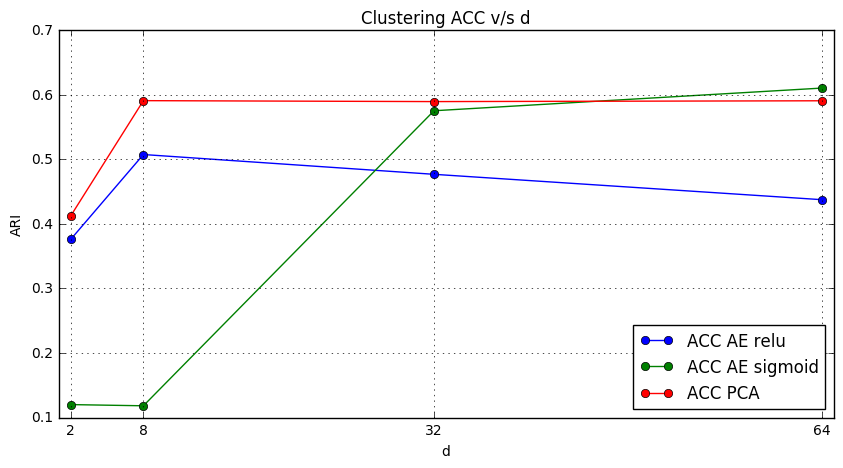

In [19]:
data_dict = {'ACC AE sigmoid': acc_ae_sigmoid, 'ACC AE relu':acc_ae_relu, 'ACC PCA':acc_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ACC v/s d', loc=4)

#### Visualización de la reconstrucción

In [20]:
def visualize_reconstruction_pca(X_test, pca_test_rec):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(pca_test_rec[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

PCA + d=8


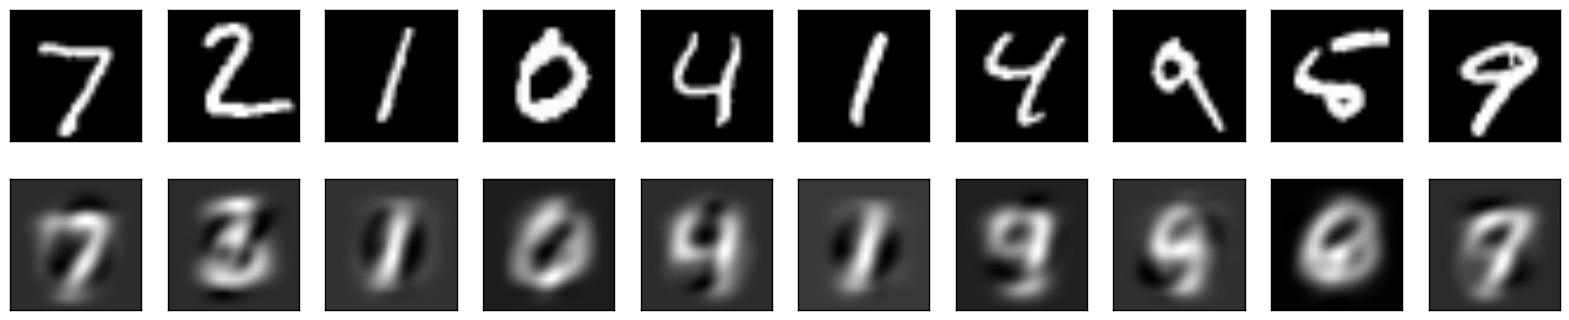

AE (sigmoid encoder) + d=8


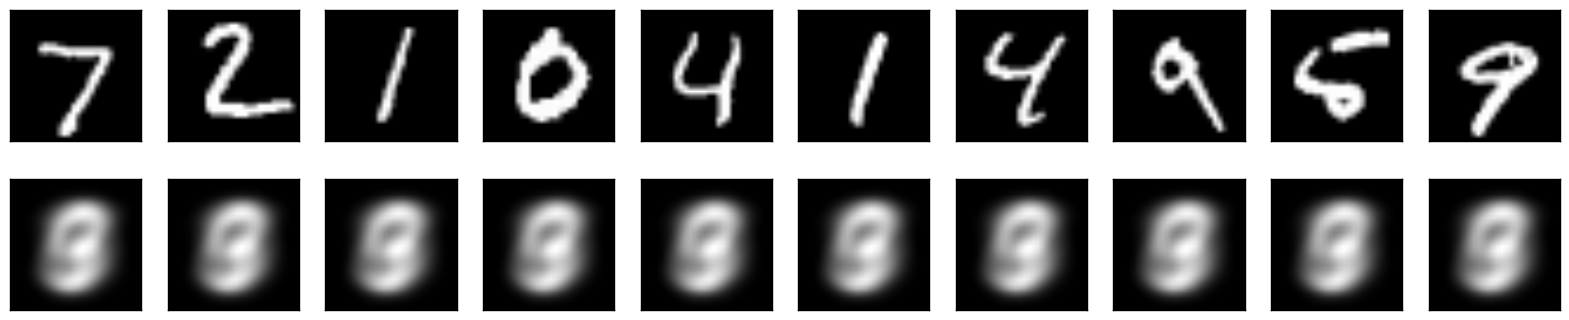

AE (relu encoder) + d=8


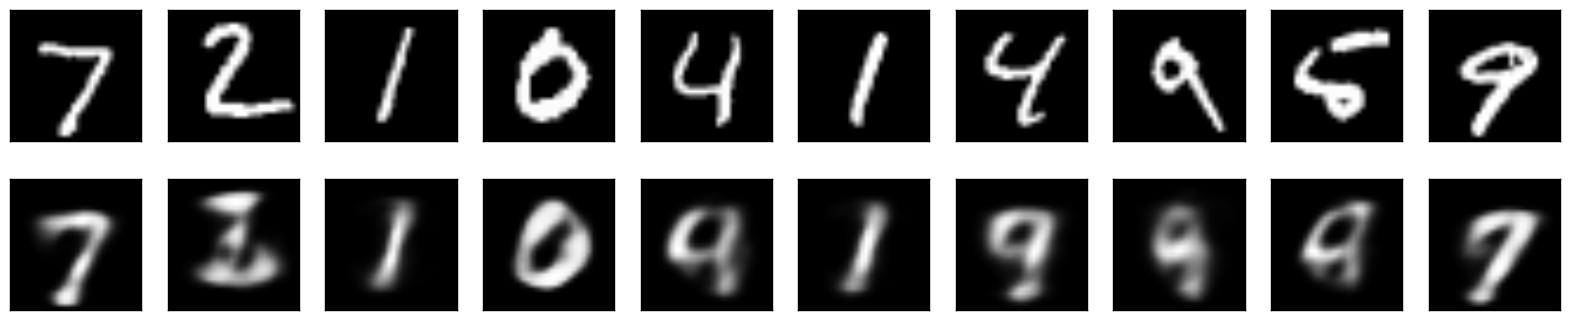

In [143]:
print('PCA + d=8')
visualize_reconstruction_pca(X_test, pca_test_rec[1])
print('AE (sigmoid encoder) + d=8')
visualize_reconstruction(X_test, ae_8d_sigmoid)
print('AE (relu encoder) + d=8')
visualize_reconstruction(X_test, ae_8d_relu)

PCA + d=64


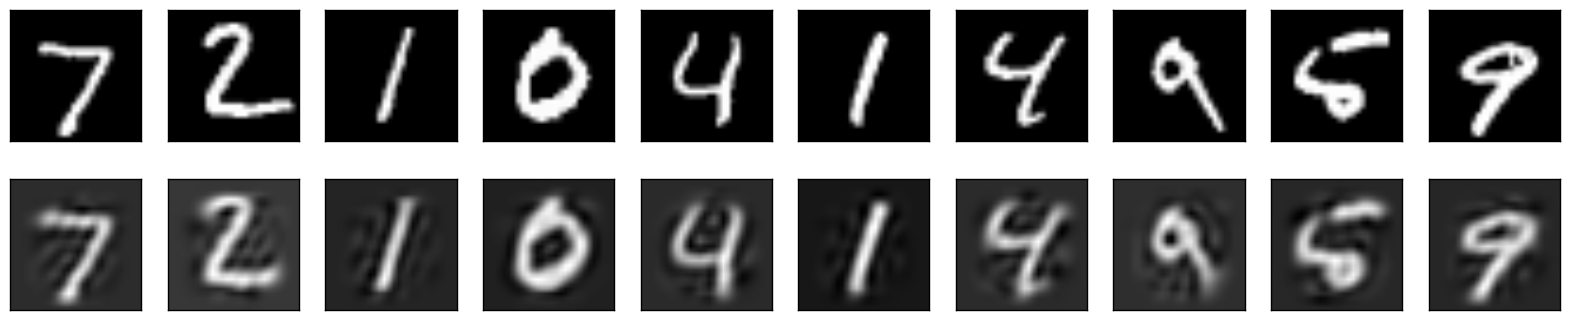

AE (sigmoid encoder) + d=64


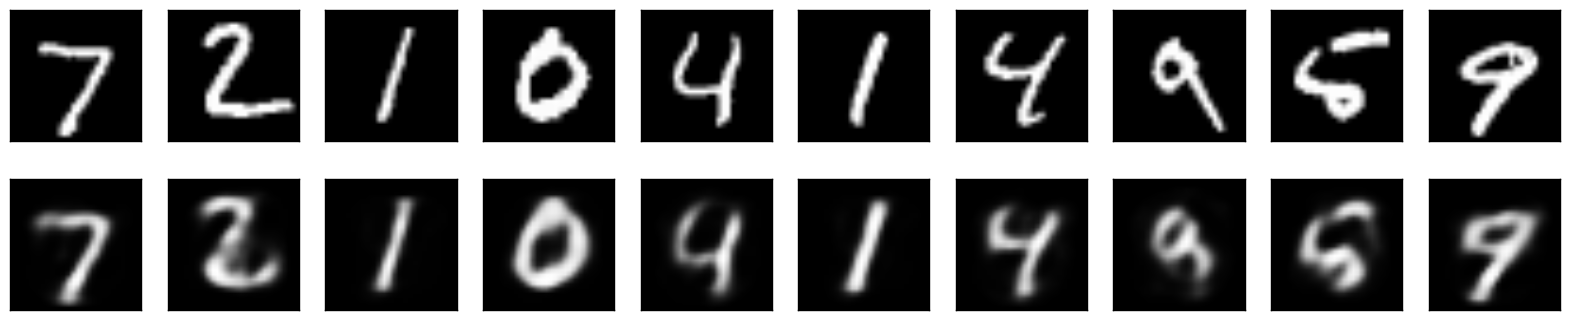

AE (relu encoder) + d=64


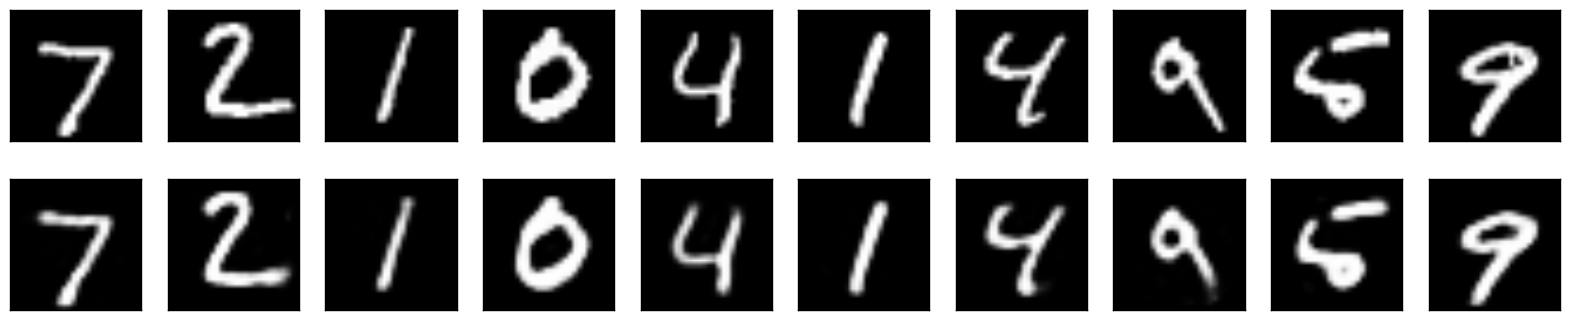

In [144]:
print('PCA + d=64')
visualize_reconstruction_pca(X_test, pca_test_rec[3])
print('AE (sigmoid encoder) + d=64')
visualize_reconstruction(X_test, ae_64d_sigmoid)
print('AE (relu encoder) + d=64')
visualize_reconstruction(X_test, ae_64d_relu)

### Parte (f)

In [21]:
def train_bernoulli_rbm(X_train, d=2):
    model = BernoulliRBM(n_components=d, batch_size=25, learning_rate=0.05, verbose=0, n_iter=50)
    model.fit(X_train)
    fileo = open('rbm_{0}d.pickle'.format(d),'wb')
    pickle.dump(model,fileo)
    fileo.close()
    return model

In [22]:
# ADVERTENCIA: la ejecucion de esta celda toma un tiempo considerable
rbm_2d = train_bernoulli_rbm(X_train, d=2)
rbm_8d = train_bernoulli_rbm(X_train, d=8)
rbm_32d = train_bernoulli_rbm(X_train, d=32)
rbm_64d = train_bernoulli_rbm(X_train, d=64)
rbm_list = [rbm_2d, rbm_8d, rbm_32d, rbm_64d]

**Nota:** Dado que la implementación de `scikit-learn` no provee un método del tipo `.inverse_transform()`, no existe una manera directa de calcular la reconstrucción que genera la RBM. Por lo mismo se han omitido los errores de reconstrucción en esta sección.

#### Desempeño en clasificación

In [48]:
ca_rbm = []
for i in range(4):
    X_train_red = rbm_list[i].transform(X_train)
    X_test_red = rbm_list[i].transform(X_test)
    ca_rbm.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )

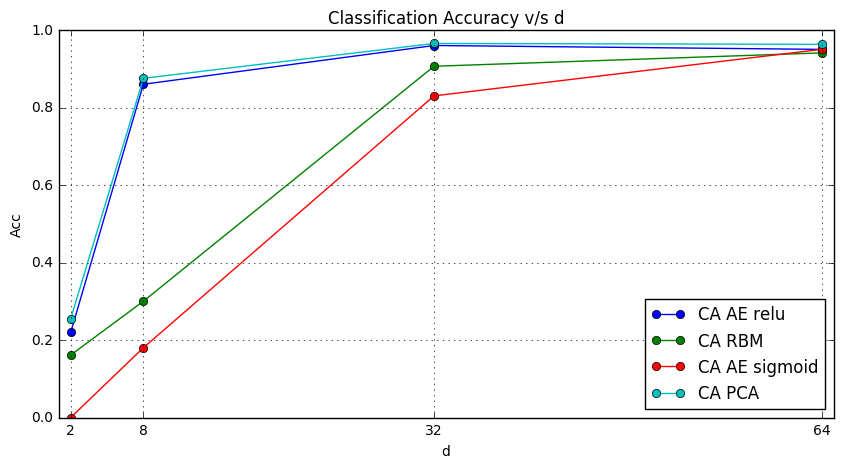

In [49]:
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu, 'CA PCA':ca_pca, 'CA RBM':ca_rbm}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

#### Desempeño en agrupamiento

In [50]:
acc_rbm = []
for i in range(4):
    X_train_red = rbm_list[i].transform(X_train)
    acc_rbm.append( clustering_scores(X_train_red, y_train, verbose=0) )

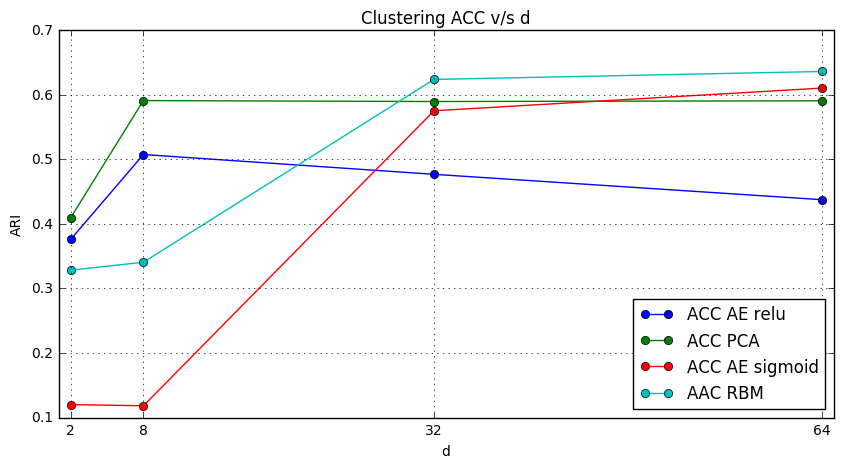

In [51]:
data_dict = {'ACC AE sigmoid': acc_ae_sigmoid, 'ACC AE relu':acc_ae_relu, 'ACC PCA':acc_pca, 'AAC RBM':acc_rbm}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ACC v/s d', loc=4)

### Parte (g)

In [45]:
def train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 2], activation='relu'):
    layers_list = []
    layers_list.append( Input(shape=(784,)) )
    # encoding model
    for size in layer_sizes:
        layers_list.append( Dense(size, activation=activation)(layers_list[-1]) )
    encoded = layers_list[-1]
    # decoding model
    for size in layer_sizes[-2::-1]:
        layers_list.append( Dense(size, activation=activation)(layers_list[-1]) )
    layers_list.append( Dense(784, activation='sigmoid')(layers_list[-1]) )
    # encoder and autoencoder model
    encoder = Model(input=layers_list[0], output=encoded)
    autoencoder = Model(input=layers_list[0], output=layers_list[-1])
    # training step
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(X_val, X_val))
    # saving results
    encoder.save('enc_{0}L_{1}d.h5'.format(len(layer_sizes), layer_sizes[-1]))
    autoencoder.save('ae_{0}L_{1}d.h5'.format(len(layer_sizes), layer_sizes[-1]))
    return autoencoder

#### `Layer size: 2`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_2L_2d = train_deep_ae(X_train, X_val, layer_sizes=[250, 2])
ae_2L_4d = train_deep_ae(X_train, X_val, layer_sizes=[250, 4])
ae_2L_8d = train_deep_ae(X_train, X_val, layer_sizes=[250, 8])
ae_2L_16d = train_deep_ae(X_train, X_val, layer_sizes=[250, 16])
ae_2L_32d = train_deep_ae(X_train, X_val, layer_sizes=[250, 32])

In [20]:
# Carga de modelos entrenados previamente
base_dir = 'results-part1/'
ae_2L_2d = load(base_dir+'ae_2L_2d'); enc_2L_2d = load(base_dir+'enc_2L_2d')
ae_2L_4d = load(base_dir+'ae_2L_4d'); enc_2L_4d = load(base_dir+'enc_2L_4d')
ae_2L_8d = load(base_dir+'ae_2L_8d'); enc_2L_8d = load(base_dir+'enc_2L_8d')
ae_2L_16d = load(base_dir+'ae_2L_16d'); enc_2L_16d = load(base_dir+'enc_2L_16d')
ae_2L_32d = load(base_dir+'ae_2L_32d'); enc_2L_32d = load(base_dir+'enc_2L_32d')

In [21]:
ae_2L = [ae_2L_2d, ae_2L_4d, ae_2L_8d, ae_2L_16d, ae_2L_32d]
enc_2L = [enc_2L_2d, enc_2L_4d, enc_2L_8d, enc_2L_16d, enc_2L_32d]
# computo de error de reconstruccion, precision de clasificacion, y precision de agrupamiento
rec_err_dae_2L = []; ca_dae_2L = []; acc_dae_2L = []
for i in range(5): 
    err = rec_err(X_test, ae_2L[i].predict(X_test)); rec_err_dae_2L.append(err)
    X_train_red = enc_2L[i].predict(X_train)
    X_test_red = enc_2L[i].predict(X_test)
    ca_dae_2L.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )
    acc_dae_2L.append( clustering_scores(X_train_red, y_train, verbose=0) )

#### `Layer size: 3`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_3L_2d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 2])
ae_3L_4d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 4])
ae_3L_8d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 8])
ae_3L_16d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 16])
ae_3L_32d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 32])

In [22]:
# Carga de modelos entrenados previamente
ae_3L_2d = load(base_dir+'ae_3L_2d'); enc_3L_2d = load(base_dir+'enc_3L_2d')
ae_3L_4d = load(base_dir+'ae_3L_4d'); enc_3L_4d = load(base_dir+'enc_3L_4d')
ae_3L_8d = load(base_dir+'ae_3L_8d'); enc_3L_8d = load(base_dir+'enc_3L_8d')
ae_3L_16d = load(base_dir+'ae_3L_16d'); enc_3L_16d = load(base_dir+'enc_3L_16d')
ae_3L_32d = load(base_dir+'ae_3L_32d'); enc_3L_32d = load(base_dir+'enc_3L_32d')

In [23]:
ae_3L = [ae_3L_2d, ae_3L_4d, ae_3L_8d, ae_3L_16d, ae_3L_32d]
enc_3L = [enc_3L_2d, enc_3L_4d, enc_3L_8d, enc_3L_16d, enc_3L_32d]
# computo de error de reconstruccion, precision de clasificacion, y precision de agrupamiento
rec_err_dae_3L = []; ca_dae_3L = []; acc_dae_3L = []
for i in range(5): 
    err = rec_err(X_test, ae_3L[i].predict(X_test)); rec_err_dae_3L.append(err)
    X_train_red = enc_3L[i].predict(X_train)
    X_test_red = enc_3L[i].predict(X_test)
    ca_dae_3L.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )
    acc_dae_3L.append( clustering_scores(X_train_red, y_train, verbose=0) )

#### `Layer size: 4`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_4L_2d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 2])
ae_4L_4d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 4])
ae_4L_8d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 8])
ae_4L_16d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 16])
ae_4L_32d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 32])

In [24]:
# Carga de modelos entrenados previamente
ae_4L_2d = load(base_dir+'ae_4L_2d'); enc_4L_2d = load(base_dir+'enc_4L_2d')
ae_4L_4d = load(base_dir+'ae_4L_4d'); enc_4L_4d = load(base_dir+'enc_4L_4d')
ae_4L_8d = load(base_dir+'ae_4L_8d'); enc_4L_8d = load(base_dir+'enc_4L_8d')
ae_4L_16d = load(base_dir+'ae_4L_16d'); enc_4L_16d = load(base_dir+'enc_4L_16d')
ae_4L_32d = load(base_dir+'ae_4L_32d'); enc_4L_32d = load(base_dir+'enc_4L_32d')

In [25]:
ae_4L = [ae_4L_2d, ae_4L_4d, ae_4L_8d, ae_4L_16d, ae_4L_32d]
enc_4L = [enc_4L_2d, enc_4L_4d, enc_4L_8d, enc_4L_16d, enc_4L_32d]
# computo de error de reconstruccion, precision de clasificacion, y precision de agrupamiento
rec_err_dae_4L = []; ca_dae_4L = []; acc_dae_4L = []
for i in range(5): 
    err = rec_err(X_test, ae_4L[i].predict(X_test)); rec_err_dae_4L.append(err)
    X_train_red = enc_4L[i].predict(X_train)
    X_test_red = enc_4L[i].predict(X_test)
    ca_dae_4L.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )
    acc_dae_4L.append( clustering_scores(X_train_red, y_train, verbose=0) )

#### Sumario de resultados

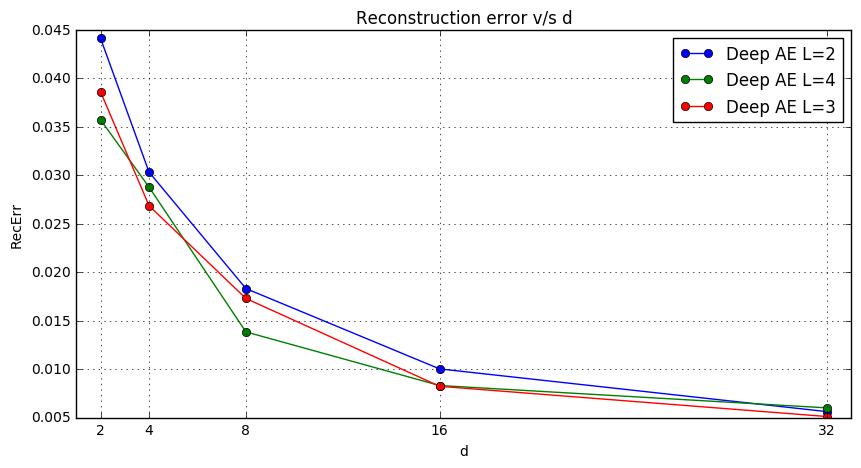

In [26]:
data_dict = {'Deep AE L=2': rec_err_dae_2L, 'Deep AE L=3': rec_err_dae_3L, 'Deep AE L=4': rec_err_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

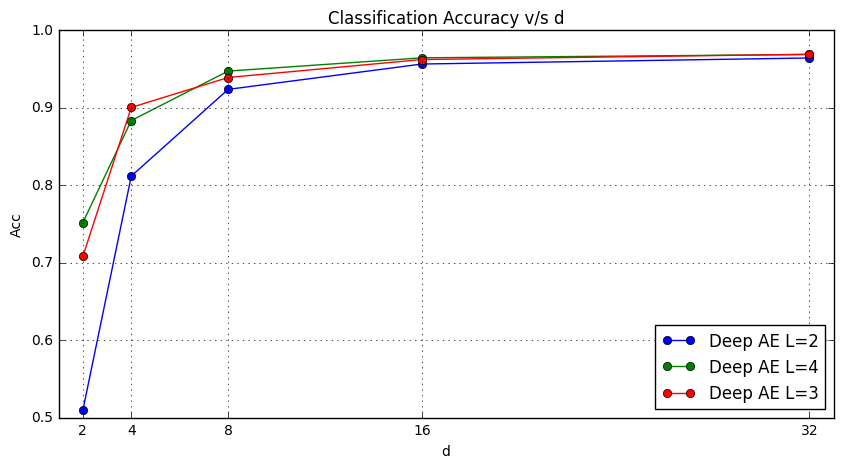

In [27]:
data_dict = {'Deep AE L=2': ca_dae_2L, 'Deep AE L=3': ca_dae_3L, 'Deep AE L=4': ca_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

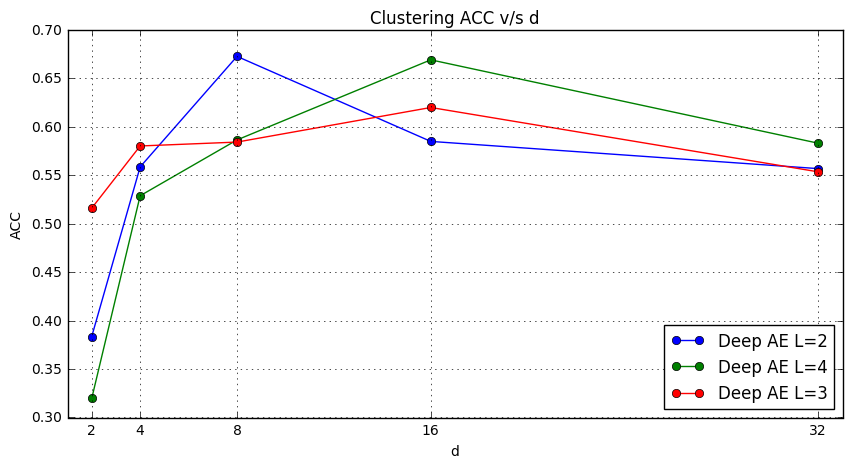

In [28]:
data_dict = {'Deep AE L=2': acc_dae_2L, 'Deep AE L=3': acc_dae_3L, 'Deep AE L=4': acc_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='ACC', title='Clustering ACC v/s d', loc=4)

### Parte (h)

In [47]:
nplot=1000

def show_representation(encoded_train, nplot=nplot, title=None):
    model = TSNE(n_components=2, random_state=0)
    encoded_train = model.fit_transform(encoded_train)
    y_train_ = np.argmax(y_train, axis=1)
    colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
    markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
    plt.figure(figsize=(5, 5))
    for idx in range(0,nplot):
        label = y_train_[idx]
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=4)
    if title is not None: plt.title(title)
    plt.show()

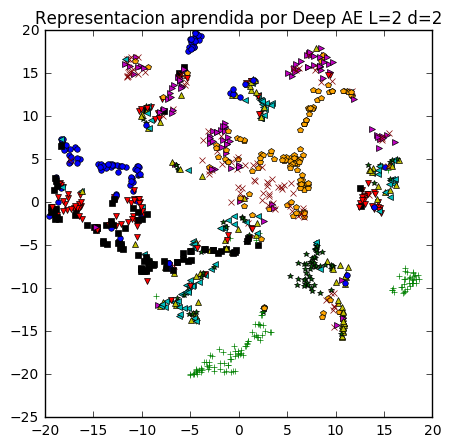

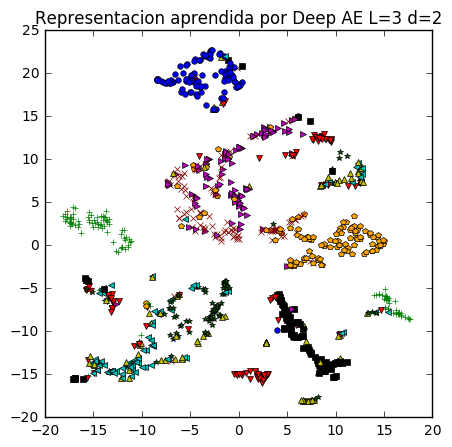

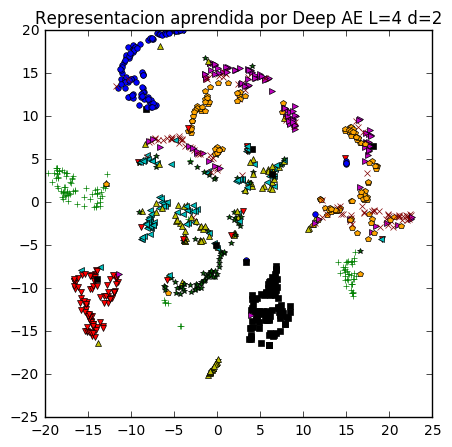

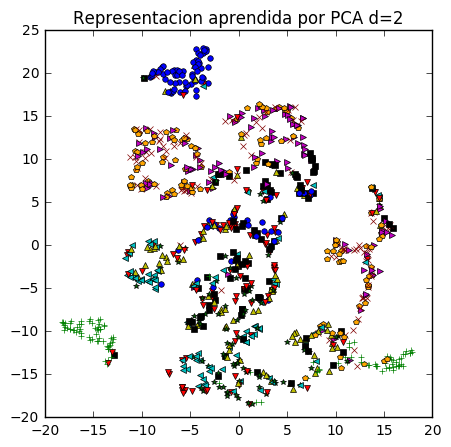

In [55]:
show_representation(enc_2L_2d.predict(X_train[:nplot]), title='Representacion aprendida por Deep AE L=2 d=2')
show_representation(enc_3L_2d.predict(X_train[:nplot]), title='Representacion aprendida por Deep AE L=3 d=2')
show_representation(enc_4L_2d.predict(X_train[:nplot]), title='Representacion aprendida por Deep AE L=4 d=2')
show_representation(pca_train_red[0][:nplot], title='Representacion aprendida por PCA d=2')

### Parte (i)

La función que se provee a continuación, muestra todo los pesos desde la capa de entrada hacia una de las neuronas de la capa oculta (tal neurona se controla con el parámetro `n`).

In [76]:
"""
ae -> Modelo de autoencoder
n -> indice de neurona de la capa oculta para la cual se muestran los pesos
"""
def visualize_weigths(ae, n=0):
    plt.figure(figsize=(10,5))
    plt.plot(range(1,785), ae.get_weights()[0][:,n])
    plt.xlabel('Input connection')
    plt.ylabel('weight value')
    plt.show()

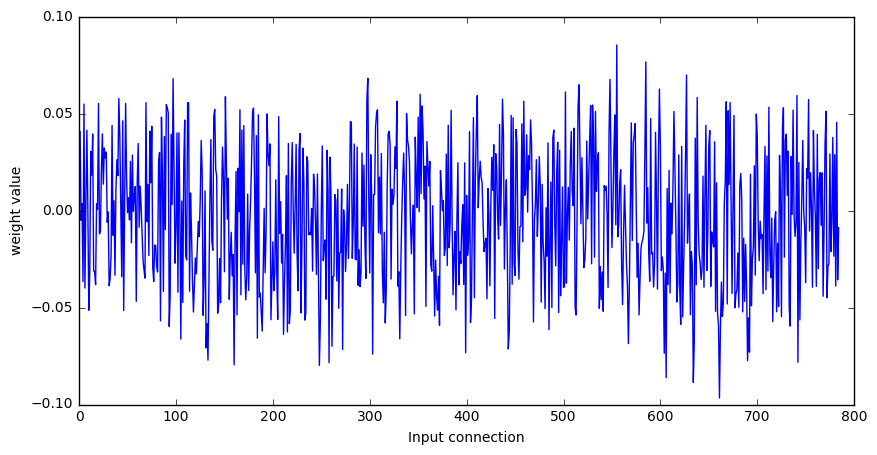

In [79]:
visualize_weigths(ae_4L_32d, n=800)

### Parte (j)

<div id='den'/>
## 1.2 - Denoising

<div id='pretr'/>
## 1.3 - Pre-entrenamiento